### Cab-Driver Agent

In [ ]:
# Importing libraries
import sys
import os
import numpy as np
import pandas as pd
import random
import time
import math
from collections import deque
import collections
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras

from IPython.display import clear_output


# Import the environment
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/RL Project"
# !ls -l
!cp Env.py TM.npy /content
%cd /content
# !ls -l
from Env import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/RL Project
/content


In [ ]:
import numpy as np
print(np.__version__)


2.0.2


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))




[]


#### Defining Time Matrix

In [ ]:
!pwd
!ls


/content
DQN_model.keras  drive	Env.py	model_weights.pkl  __pycache__	sample_data  TM.npy


In [ ]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [ ]:
print(Time_matrix.shape)
print(Time_matrix[3][4][17][5]) #Example: (Returns Time Taken) 𝑇𝑖𝑚𝑒−𝑚𝑎𝑡𝑟𝑖𝑥[𝑠𝑡𝑎𝑟𝑡−𝑙𝑜𝑐][𝑒𝑛𝑑−𝑙𝑜𝑐][ℎ𝑜𝑢𝑟−𝑜𝑓−𝑡ℎ𝑒−𝑑𝑎𝑦] [𝑑𝑎𝑦−𝑜𝑓−𝑡ℎ𝑒−𝑤𝑒𝑒𝑘]

(5, 5, 24, 7)
6.0


For<br>𝑠𝑡𝑎𝑟𝑡−𝑙𝑜𝑐: **3**<br>𝑒𝑛𝑑−𝑙𝑜𝑐: **4**<br>ℎ𝑜𝑢𝑟−𝑜𝑓−𝑡ℎ𝑒−𝑑𝑎𝑦: **17**<br>𝑑𝑎𝑦−𝑜𝑓−𝑡ℎ𝑒−𝑤𝑒𝑒𝑘: **5**<br>The time taken by the cab driver is **6.0 hours**.        

In [ ]:
## Understanding the min and max time duration of trips from one point to another

print("Minimimum time taken:", Time_matrix.min())
print("Maximum time taken:", Time_matrix.max())
print("Average time taken:", Time_matrix.mean())

Minimimum time taken: 0.0
Maximum time taken: 11.0
Average time taken: 3.0542857142857143


The maximum time taken is 11 hours. So, it is safe to say that the maximum time taken by the cab driver to move from one point to another is less than 1 day.

In [ ]:
## Check Random State
from Env import CabDriver
print("Random State Initialization:")
for i in range(5):         ## Checking for 5 epsiodes
    env= CabDriver()
    random_state_init= env.state_init
    print(random_state_init)

Random State Initialization:
(4, 9, 3)
(0, 11, 0)
(0, 12, 2)
(1, 13, 6)
(4, 20, 0)


In [ ]:
## Creating tuples of action_index and actions from action_space
from Env import CabDriver
env= CabDriver()
cab_action_space = env.action_space
cab_action_indices =[i for i in range(len(cab_action_space))]
action_list= [i for i in zip(cab_action_indices, cab_action_space)]   ## tuples (action_indices, action)
print("Action List (action_indices, action):")
action_list

Action List (action_indices, action):


[(0, (0, 0)),
 (1, (0, 1)),
 (2, (0, 2)),
 (3, (0, 3)),
 (4, (0, 4)),
 (5, (1, 0)),
 (6, (1, 2)),
 (7, (1, 3)),
 (8, (1, 4)),
 (9, (2, 0)),
 (10, (2, 1)),
 (11, (2, 3)),
 (12, (2, 4)),
 (13, (3, 0)),
 (14, (3, 1)),
 (15, (3, 2)),
 (16, (3, 4)),
 (17, (4, 0)),
 (18, (4, 1)),
 (19, (4, 2)),
 (20, (4, 3))]

In [ ]:
## Understanding state_size
state_size= m+t+d               ## Considering DQN_Architecture 2 (Input: State Only)
print("state_size:", state_size)

state_size: 36


In [ ]:
## Understanding action_size
action_size= len(env.action_space)
print("action_size:",action_size)

action_size: 21


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.00075
        self.epsilon_min = 0.0000001

        self.batch_size = 32
        # Create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked for all samples
        self.states_tracked_1 = []
        self.states_tracked_2 = []


        # For Sample state-action pair 1: We are going to track state (2,4,6) and action (2,3) at index 11 in the action space.
        self.track_state_1 = np.array(env.state_encod_arch2((2,4,6))).reshape(1, self.state_size)

        # For Sample state-action pair 2: We are going to track state (1,2,3) and action (1,2) at index 6 in the action space.
        self.track_state_2 = np.array(env.state_encod_arch2((1,2,3))).reshape(1, self.state_size)


        # Create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Takes in the agent and constructs a neural network to train it and returns model and parameters.
        """
        model = Sequential()
        # Write your code here: Add layers to your neural nets

        # Hidden Layers
        model.add(Dense(32, input_dim= self.state_size, activation= 'relu', kernel_initializer= 'he_uniform'))
        model.add(Dense(32, activation= 'relu', kernel_initializer= 'he_uniform'))

        # the output layer: output is of size of number of actions (action_size) and returns Q values for all actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        # Compile Model
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary

        return model



    def get_action(self, state):

    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment

        # Get a list of the ride requests driver got.
        possible_actions_index, actions= env.requests(state)

        # get action from model using epsilon-greedy policy
        z = np.random.random()  ## variable z randomly chooses a value between [0,1)
        if z <= self.epsilon:
            # explore: choose a random action from all possible actions
            return random.randrange(self.action_size)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch2(state)).reshape(1, self.state_size)

            # Use the model to predict the Q_values.
            q_vals = self.model.predict(state)

            # Truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = np.array([q_vals[0][i] for i in possible_actions_index])

            return possible_actions_index[np.argmax(q_vals_possible)]


    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory. Also, taking argument 'done' --> terminal state flag.
        self.memory.append((state, action_index, reward, next_state, done))


    # pick samples randomly from replay memory (with batch_size) and train the network
    # @tf.function
    def train_model(self):
        """
        Function to train the model on each step run.
        Picks the random memory events according to batch size and
        runs it through the network to train it.
        """
        # Write your code from here
        # 1. Update your 'update_output' and 'update_input' batch
        # 2. Predict the target from earlier model
        # 3. Get the target for the Q-network

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

             # Update your 'update_output' and 'update_input' batch
            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch2(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:      #terminal state
                    target[i][actions[i]] = rewards[i]
                else:            # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
             # 4. Fit your model and track the loss values
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)



    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value_1 = self.model.predict(self.track_state_1)
        q_value_2 = self.model.predict(self.track_state_2)


        # Grab the q_value of the action index that we are tracking.
        self.states_tracked_1.append(q_value_1[0][11])    ## action (2,3) at index 11 in the action space
        self.states_tracked_2.append(q_value_2[0][6])     ## action (1,2) at index 6 in the action space


    def save_weights_numpy(self, name):      ## Saves the 'model_weights' in a  pickle file
        weights= self.model.get_weights()   ## Gets model_weights as a list of numpy arrays
        try:
            fpkl= open(name, 'wb')
            pickle.dump(weights, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
        except Exception as e:
            print(e)

    def save(self, name):
        self.model.save(name)      ## Saves the DQN_model in Keras H5 format

In [ ]:
# 1) Utility functions for saving/loading random states & replay buffer
def save_random_states(filename="random_states.pkl"):
    """Saves Python and NumPy random states to a file."""
    state_dict = {
        'py_state': random.getstate(),
        'np_state': np.random.get_state()
    }
    with open(filename, 'wb') as f:
        pickle.dump(state_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_random_states(filename="random_states.pkl"):
    """Loads Python and NumPy random states from a file."""
    with open(filename, 'rb') as f:
        state_dict = pickle.load(f)
    random.setstate(state_dict['py_state'])
    np.random.set_state(state_dict['np_state'])

def save_replay_buffer(agent, filename="replay_buffer.pkl"):
    """Saves the agent's replay memory (deque) as a list."""
    mem_list = list(agent.memory)  # Convert deque to list
    with open(filename, 'wb') as f:
        pickle.dump(mem_list, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_replay_buffer(agent, filename="replay_buffer.pkl"):
    """Loads the agent's replay memory from a list into the agent's deque."""
    with open(filename, 'rb') as f:
        mem_list = pickle.load(f)
    agent.memory = deque(mem_list, maxlen=agent.memory.maxlen)

def save_tracking_arrays(agent, filename="tracking_arrays.pkl"):
    """Save the tracking arrays from the agent."""
    tracking_data = {
      'states_tracked_1': agent.states_tracked_1,
      'states_tracked_2': agent.states_tracked_2
    }
    with open(filename, "wb") as f:
      pickle.dump(tracking_data, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_tracking_arrays(agent, filename="tracking_arrays.pkl"):
    """Load the tracking arrays and set them in the agent."""
    with open(filename, "rb") as f:
        tracking_data = pickle.load(f)
    agent.states_tracked_1 = tracking_data.get('states_tracked_1', [])
    agent.states_tracked_2 = tracking_data.get('states_tracked_2', [])

In [ ]:
# episode_time = 24*30   # 24 hrs for 30 days per episode
# Episodes = 3   # No. of Episodes
# m = 5                  # No. Locations
# t = 24                 # No. of hrs in a day
# d = 7                  # No. of days in a week

# # Invoke Env class
# env = CabDriver()
# action_space, state_space, state = env.reset()

# # Set up state and action sizes.
# state_size = m+t+d   #Using Architecture 2 (input:state)
# action_size = len(action_space)

# # Invoke agent class
# agent = DQNAgent(action_size=action_size, state_size=state_size)


# # to store rewards in each episode
# rewards_per_episode, episodes = [], []
# # Rewards for state
# rewards_init_state = []

### DQN block

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent
    
    
    while !terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        

In [ ]:
# !rm "/content/drive/MyDrive/Colab Notebooks/RL Project/checkpoint_info.pkl"
# !rm "/content/drive/MyDrive/Colab Notebooks/RL Project/DQN_model.keras"
# !rm "/content/drive/MyDrive/Colab Notebooks/RL Project/random_states.pkl"
# !rm "/content/drive/MyDrive/Colab Notebooks/RL Project/replay_buffer.pkl"
# !rm "/content/drive/MyDrive/Colab Notebooks/RL Project/tracking_arrays.pkl"
# !rm "/content/drive/MyDrive/Colab Notebooks/RL Project/score_tracked.pkl"

In [ ]:
# ------------------------------------------------
# 1) Hyperparameters
# ------------------------------------------------
Episodes = 8600
episode_time = 100     # 720 hours (adjust as needed)
m = 5
t = 24
d = 7

# 2) Environment & initial setup
env = CabDriver()
action_space, state_space, state = env.reset()
state_size = m + t + d
action_size = len(action_space)

# 3) Create DQNAgent
agent = DQNAgent(action_size=action_size, state_size=state_size)

# 4) Filenames for checkpoints and saved data
checkpoint_file = "/content/drive/MyDrive/Colab Notebooks/RL Project/checkpoint_info.pkl"
model_file = "/content/drive/MyDrive/Colab Notebooks/RL Project/DQN_model.keras"
random_states_file = "/content/drive/MyDrive/Colab Notebooks/RL Project/random_states.pkl"
replay_buffer_file = "/content/drive/MyDrive/Colab Notebooks/RL Project/replay_buffer.pkl"
tracking_file = "/content/drive/MyDrive/Colab Notebooks/RL Project/tracking_arrays.pkl"
score_tracked_file = "/content/drive/MyDrive/Colab Notebooks/RL Project/score_tracked.pkl"

# 5) Load existing checkpoint if it exists
last_completed_episode = 0
score_tracked = []  # Initialize. globally

if (os.path.exists(checkpoint_file) and
    os.path.exists(model_file) and
    os.path.exists(random_states_file) and
    os.path.exists(replay_buffer_file) and
    os.path.exists(tracking_file) and
    os.path.exists(score_tracked_file)):

    print("Found existing checkpoint & model. Loading to resume training...")

    # Load last completed episode index
    with open(checkpoint_file, 'rb') as f:
        last_completed_episode = pickle.load(f)

    # Load model weights
    agent.model.load_weights(model_file)
    print(f"Continuing from episode {last_completed_episode}.")

    # Load random states
    load_random_states(random_states_file)
    print("Random states loaded.")

    # Load replay buffer
    load_replay_buffer(agent, replay_buffer_file)
    print("Replay buffer loaded.")

    # Load tracking arrays
    load_tracking_arrays(agent, tracking_file)
    print("Tracking arrays loaded.")

    # Load score_tracked
    with open(score_tracked_file, "rb") as f:
        score_tracked = pickle.load(f)
    print("Score tracked loaded.")

else:
    print("No complete checkpoint found. Starting from scratch.")

# 6) If we've already completed or exceeded desired episodes, skip training
if last_completed_episode >= Episodes:
    print(f"Model already trained up to or beyond {Episodes} episodes. Skipping training.")
else:
    # 7) Training Loop with GPU device context
    with tf.device('/device:GPU:0'):
        start_time = time.time()

        rewards_per_episode = []
        episodes_list = []
        # score_tracked is already defined above (either loaded or empty)

        # Start from last_completed_episode up to Episodes
        for episode in tqdm(range(last_completed_episode, Episodes), desc="Training Progress"):
            done = False
            score = 0

            # Reset environment
            env = CabDriver()
            action_space, state_space, state = env.reset()
            initial_state = state

            total_time = 0

            while not done:
                # 1. Epsilon-greedy action
                action = agent.get_action(state)

                # 2. Step in environment
                next_state, reward, step_time = env.step(state, env.action_space[action], Time_matrix)

                # 3. Check time limit
                total_time += step_time
                if total_time > episode_time:
                    done = True
                else:
                    # 4. Replay buffer + training
                    agent.append_sample(state, action, reward, next_state, done)
                    if len(agent.memory) > agent.batch_size:
                        agent.train_model()

                    # 5. Accumulate reward & update state
                    score += reward
                    state = next_state

            # Episode end: track reward
            rewards_per_episode.append(score)
            episodes_list.append(episode)

            # Epsilon decay
            agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * \
                            np.exp(agent.epsilon_decay * episode)

            # Logging every 10 episodes
            if (episode + 1) % 10 == 0:
                print("episode {}, initial_state {}, reward {}, memory_length {}, epsilon {}, total_time {}"
                      .format(episode, initial_state, score, len(agent.memory), agent.epsilon, total_time))

            # Save Q-values for sample states every 5 episodes
            if (episode + 1) % 5 == 0:
                agent.save_tracking_states()

            # Track total rewards
            score_tracked.append(score)

            # Save model & weights (and everything else) every 100 episodes
            if (episode + 1) % 25 == 0:
                print(f"Saving Model at episode {episode+1}")
                agent.save(name=model_file)
                print(f"Saving Weights at episode {episode+1}")
                agent.save_weights_numpy(name="model_weights.pkl")

                # Save random states, replay buffer, and tracking arrays
                save_random_states(random_states_file)
                save_replay_buffer(agent, replay_buffer_file)
                save_tracking_arrays(agent, tracking_file)
                print(f"Random states, replay buffer & tracking arrays saved at episode {episode+1}")

                # Update last_completed_episode checkpoint
                last_completed_episode = episode + 1
                with open(checkpoint_file, "wb") as f:
                    pickle.dump(last_completed_episode, f)

                # Save the current score_tracked
                with open(score_tracked_file, "wb") as f:
                    pickle.dump(score_tracked, f)

        # Final saving after finishing all episyodes
        agent.save(name=model_file)
        agent.save_weights_numpy(name="model_weights.pkl")
        save_random_states(random_states_file)
        save_replay_buffer(agent, replay_buffer_file)
        save_tracking_arrays(agent, tracking_file)

        last_completed_episode = Episodes
        with open(checkpoint_file, "wb") as f:
            pickle.dump(last_completed_episode, f)

        # Save final score_tracked data
        with open(score_tracked_file, "wb") as f:
            pickle.dump(score_tracked, f)

        elapsed_time = time.time() - start_time
        print("Training completed in", elapsed_time, "seconds.")
        print(f"Training finished at episode {last_completed_episode} out of {Episodes}.")


Found existing checkpoint & model. Loading to resume training...
Continuing from episode 8675.
Random states loaded.
Replay buffer loaded.
Tracking arrays loaded.
Score tracked loaded.
Model already trained up to or beyond 8600 episodes. Skipping training.


The episode total time limit is `720 i.e. 24*30 hours`. However, we see the total time at the end of each episode crosses 720 hours limit. This is because the cab driver accepts the last ride prior to the end of total time (720 hours). Hence, the cab driver has to complete the last trip in order to complete the episode.

### Saving DQN_Model and Model Weights

In [ ]:
# Save the complete DQN model (architecture + weights + optimizer state) in Keras native format
agent.model.save("DQN_model.keras")
weights = agent.model.get_weights()  # Extract model weights as a list of numpy arrays
with open("model_weights.pkl", "wb") as f:
    pickle.dump(weights, f)

In [ ]:
## Verifying the 'model_weights.pkl' file generated
model_weights_path = r"model_weights.pkl"
model_weights= pd.read_pickle(model_weights_path)   ## List of Numpy arrays of model_weights
model_weights

[array([[ 1.5515716 ,  1.7042857 , -4.7532763 , ...,  1.1885431 ,
         -1.5026262 , -2.4204717 ],
        [-4.3332586 , -4.3798847 , -4.412542  , ...,  1.0428016 ,
         -4.1775002 ,  2.1185846 ],
        [-5.0599713 , -5.6059475 ,  1.9607627 , ..., -7.476563  ,
          0.5911459 , -7.885524  ],
        ...,
        [ 1.2872704 , -5.803964  ,  1.4631289 , ...,  2.191023  ,
          1.3806427 ,  0.5470384 ],
        [-3.1625545 ,  0.05143495, -4.6603584 , ...,  0.23291776,
         -1.9888908 ,  0.23130564],
        [-0.34392554,  2.7709963 ,  0.85899496, ..., -7.1193433 ,
         -0.1933458 , -0.36125565]], dtype=float32),
 array([-6.0615525 , -4.555266  , -2.298533  , -6.341694  , -3.418138  ,
        -4.6841083 , -6.477551  , -2.1110055 , -2.3058498 , -4.47112   ,
        -3.2800987 , -4.3451276 ,  2.4511068 , -5.4275484 , -2.499219  ,
        -4.4291425 , -0.77098995, -5.099042  , -4.7592864 , -2.6527123 ,
        -0.7697512 , -2.4827898 , -2.6107666 , -3.626733  , -5.384

### Model Prediction (Loading Saved DQN_Model)

In [ ]:
## Loading the saved 'DQN_model.keras' (to test for prediction)
from keras.models import load_model
model = load_model(model_file)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 32)                  │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 21)                  │             693 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,801 (34.38 KB)

 Trainable params: 2,933 (11.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,868 (22.93 KB)

In [ ]:
## Creating a function to make model predictions:
def model_predict(state, state_size= m+t+d):
    state_encoded= np.array(env.state_encod_arch2(state)).reshape(1, state_size)

    # Predict the action for given state
    action= action_space[np.argmax(model.predict(state_encoded))]
    print();print("*"*20+ " Model Prediction " +"*"*20)
    print(f"Predicted action corresponding to state {state}:",action)
    print("*"*58)

In [ ]:
## Model Prediction: Example 1: state (3,3,4)
model_predict(state=(3,3,4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

******************** Model Prediction ********************
Predicted action corresponding to state (3, 3, 4): (3, 1)
**********************************************************


In [ ]:
## Model Prediction: Example 2:  state (1,10,3)
model_predict(state=(1,10,3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

******************** Model Prediction ********************
Predicted action corresponding to state (1, 10, 3): (1, 2)
**********************************************************


In [ ]:
## Model Prediction: Example 3: state (2,2,5)
model_predict(state=(2,2,5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

******************** Model Prediction ********************
Predicted action corresponding to state (2, 2, 5): (2, 1)
**********************************************************


In [ ]:
## Model Prediction: Example 4: state (1,1,1)
model_predict(state=(1,1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

******************** Model Prediction ********************
Predicted action corresponding to state (1, 1, 1): (1, 2)
**********************************************************


### Tracking Convergence

**Q_values for Sample state-action pairs tracked**

In [ ]:
# For Sample state_action pair 1: State (2,4,6), Action (2,3)
agent.states_tracked_1

[np.float32(129.3765),
 np.float32(1520.272),
 np.float32(339.04248),
 np.float32(230.3859),
 np.float32(205.76901),
 np.float32(211.15819),
 np.float32(223.94167),
 np.float32(225.84515),
 np.float32(209.8912),
 np.float32(210.95992),
 np.float32(238.89046),
 np.float32(199.37358),
 np.float32(193.65878),
 np.float32(216.46315),
 np.float32(203.88115),
 np.float32(189.52985),
 np.float32(183.14674),
 np.float32(176.93042),
 np.float32(205.7758),
 np.float32(226.2917),
 np.float32(198.33351),
 np.float32(244.0639),
 np.float32(338.53223),
 np.float32(254.46042),
 np.float32(314.1906),
 np.float32(345.01224),
 np.float32(272.17023),
 np.float32(344.93234),
 np.float32(343.53357),
 np.float32(322.66766),
 np.float32(316.1329),
 np.float32(385.0191),
 np.float32(406.30057),
 np.float32(318.6999),
 np.float32(537.55115),
 np.float32(314.68155),
 np.float32(351.10037),
 np.float32(368.40454),
 np.float32(432.74832),
 np.float32(433.94626),
 np.float32(415.58694),
 np.float32(390.8878),
 np.

In [ ]:
# For Sample state_action pair 2: State (1,2,3), Action (1,2)
agent.states_tracked_2

[np.float32(252.86038),
 np.float32(1496.3673),
 np.float32(377.61435),
 np.float32(271.82327),
 np.float32(233.3783),
 np.float32(242.26466),
 np.float32(245.83192),
 np.float32(249.79814),
 np.float32(228.38303),
 np.float32(221.66013),
 np.float32(248.9209),
 np.float32(206.34537),
 np.float32(202.99869),
 np.float32(226.36214),
 np.float32(207.47285),
 np.float32(196.97185),
 np.float32(187.3216),
 np.float32(183.69511),
 np.float32(216.07523),
 np.float32(234.04025),
 np.float32(213.17683),
 np.float32(286.0543),
 np.float32(365.67307),
 np.float32(275.83514),
 np.float32(329.1907),
 np.float32(368.7947),
 np.float32(295.13455),
 np.float32(390.48843),
 np.float32(361.35797),
 np.float32(347.32733),
 np.float32(314.8413),
 np.float32(415.49213),
 np.float32(403.80743),
 np.float32(353.53677),
 np.float32(519.16235),
 np.float32(336.48804),
 np.float32(371.5386),
 np.float32(372.3375),
 np.float32(447.72556),
 np.float32(445.22452),
 np.float32(470.83795),
 np.float32(412.89813),
 

### Tracking the state-action pairs for checking convergence


#### (i) Sample a few state-action pairs and plot their Q-values along episodes (Convergence Graphs)

In [ ]:
def convergence_graph_q_val(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked)))
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
    plt.xlabel("No. of Episodes  (step increment of 5)", fontsize=13, fontstyle='italic')
    plt.show()

In [ ]:
def convergence_graph_q_val_logscale(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values (log scale) for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked)))
    plt.yscale('log')
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values (log_scale)", fontsize=13, fontstyle='italic')
    plt.xlabel("No. of Episodes  (step increment of 5)", fontsize=13, fontstyle='italic')
    plt.show()


Tracking Convergence for state-action pair 1: State (2,4,6), Action (2,3)



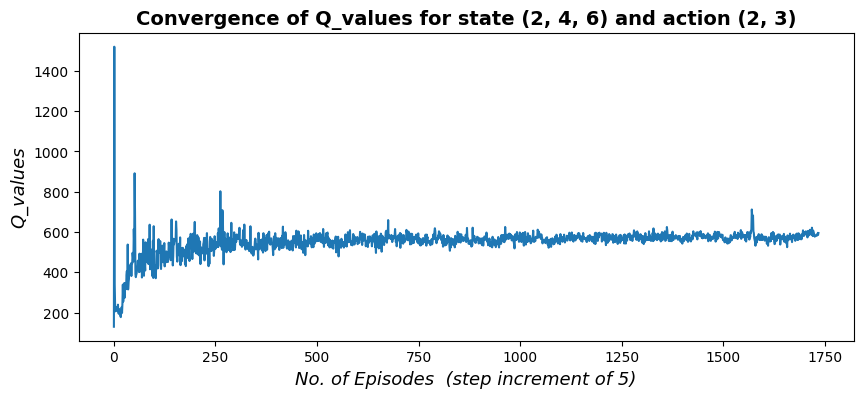

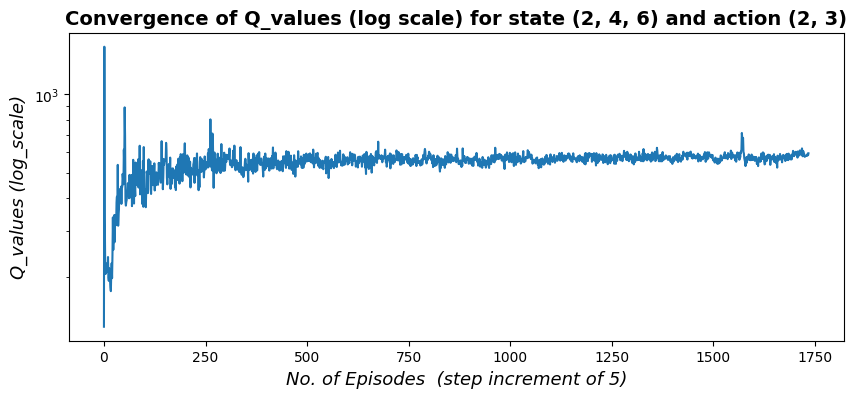




Tracking Convergence for state-action pair 2: State (1,2,3), Action (1,2)



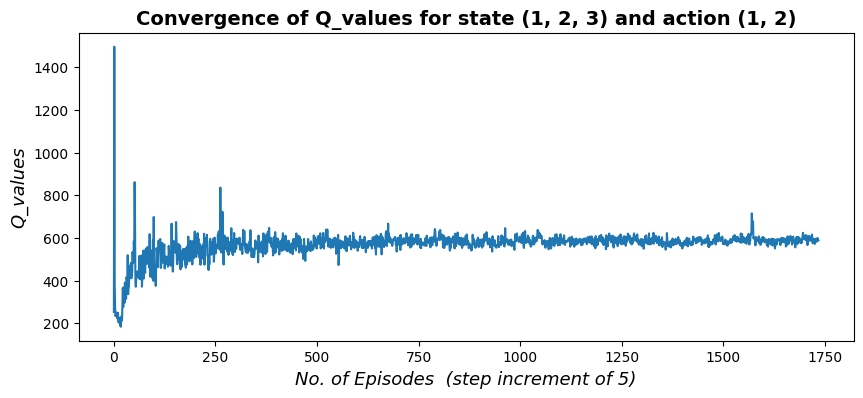

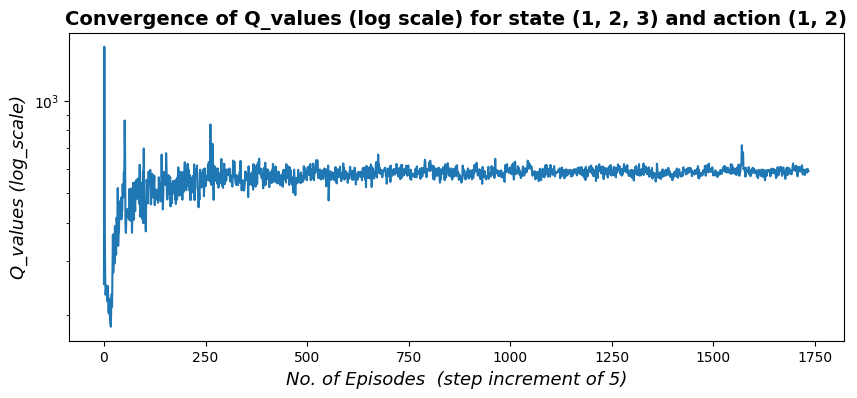

In [ ]:
## Convergence Graph 1: For Sample state-action pair 1: State (2,4,6), Action (2,3)
print('\n\033[1m'+"Tracking Convergence for state-action pair 1: State (2,4,6), Action (2,3)\n")
convergence_graph_q_val(fig_num=1, state=(2,4,6), action=(2,3), states_tracked= agent.states_tracked_1)
convergence_graph_q_val_logscale(fig_num=2, state=(2,4,6), action=(2,3), states_tracked= agent.states_tracked_1)

## Convergence Graph 2: For Sample state-action pair 2: State (1,2,3), Action (1,2)
print('\n\n\n\033[1m'+"Tracking Convergence for state-action pair 2: State (1,2,3), Action (1,2)\n")
convergence_graph_q_val(fig_num=3, state=(1,2,3), action=(1,2), states_tracked= agent.states_tracked_2)
convergence_graph_q_val_logscale(fig_num=4, state=(1,2,3), action=(1,2), states_tracked= agent.states_tracked_2)

Thus, from the graphs we can deduce that the sample state-action pairs `'State (2,4,6), Action (2,3)'` and `'State (1,2,3), Action (1,2)'` show convergence over episodes.

#### (ii) Check whether the total rewards earned per episode are showing stability

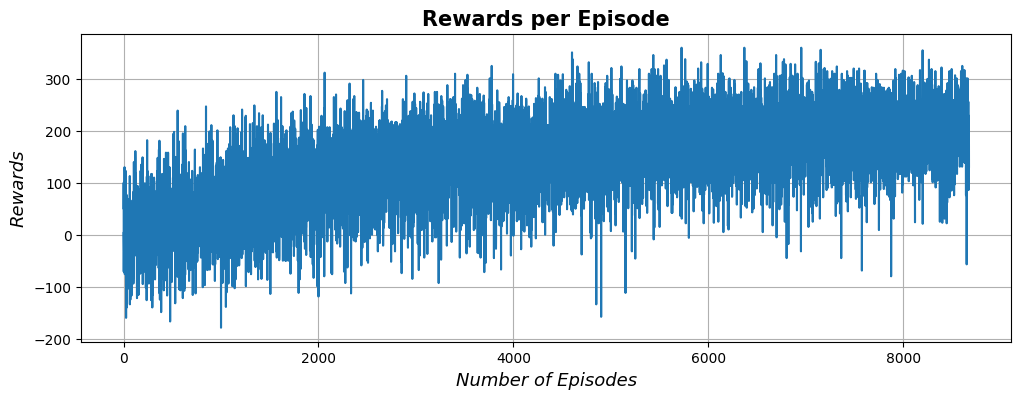

In [ ]:
## Rewards (y-axis) vs episodes (x-axis)
plt.figure(5, figsize=(12,4))
plt.title('Rewards per Episode', fontsize=15, fontweight='bold')
xaxis = np.asarray(range(0, len(score_tracked)))
plt.plot(xaxis,np.asarray(score_tracked))
plt.ylabel("Rewards", fontsize=13, fontstyle='italic')
plt.xlabel("Number of Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show()

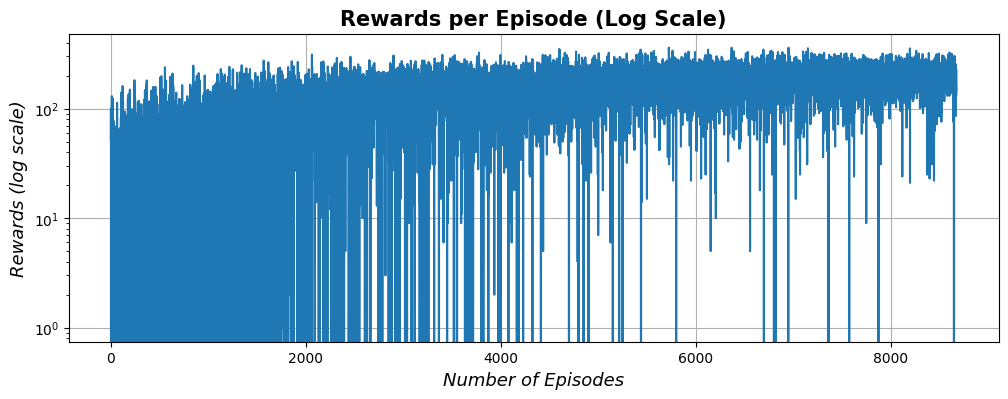

In [ ]:
## Rewards (y-axis log scale) vs episodes
plt.figure(6, figsize=(12,4))
plt.title('Rewards per Episode (Log Scale)', fontsize=15, fontweight='bold')
xaxis = np.asarray(range(0, len(score_tracked)))
plt.plot(xaxis,np.asarray(score_tracked))
plt.yscale('log')                                                 ## Log scale: On y-axis
plt.ylabel("Rewards (log scale)", fontsize=13, fontstyle='italic')
plt.xlabel("Number of Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show()

From Rewards per Episode (Log scale) graph, we clearly see that the `rewards are quite consistent after 7500 episodes. Thus, showing the model stability.` Hence we can conclude that our model shows decent convergence post 7500 episodes.

### Epsilon-Decay Check

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

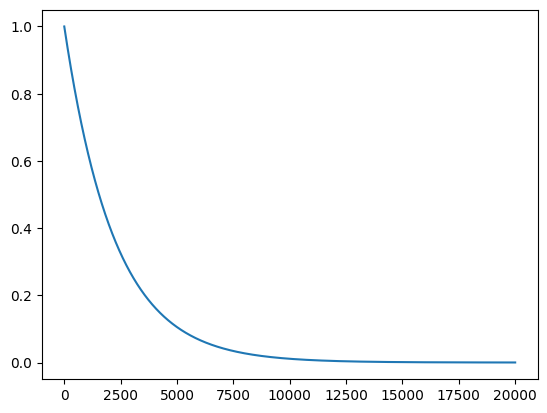

In [ ]:
time = np.arange(0,20000)
epsilon = []
for i in range(0,20000):
    epsilon.append(0.0000001 + (1 - 0.0000001) * np.exp(-0.00045*i))

plt.plot(time, epsilon)
plt.show()